<a href="https://colab.research.google.com/github/vinicius-mattoso/Exploratory-Data-Analysis-EDA-/blob/main/Handling_Missing_Values/Handling_Missing_Values_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Handling Missing Values
---

Drop missing values, or fill them in with an automated workflow.

Ao longo desse notebook vão conter uma junção entre os códigos apresentados ao longo das aulas do curso da Kaggle sobre tratamento de dados e linhas de códigos autorais que também julgo ser importantes de serem avaliadas.

Esse notebook é para auxiliar no processo de limpeza dos dados, uma vez que normalmente temos linhas com coluna faltantes. E tratar esse problema com a simples remoção da linha inteira pode acarretar em prejuízos para o seu dataset.
Ao longo desse notebook vamos apresentar formas de identificar e tratar esse tipo de problema.

### Examinando o dataset

---
### Atenção
---
 
Os arquivos necessários para esse notebook se encontram no Kaggle


https://www.kaggle.com/datasets/maxhorowitz/nflplaybyplay2009to2016

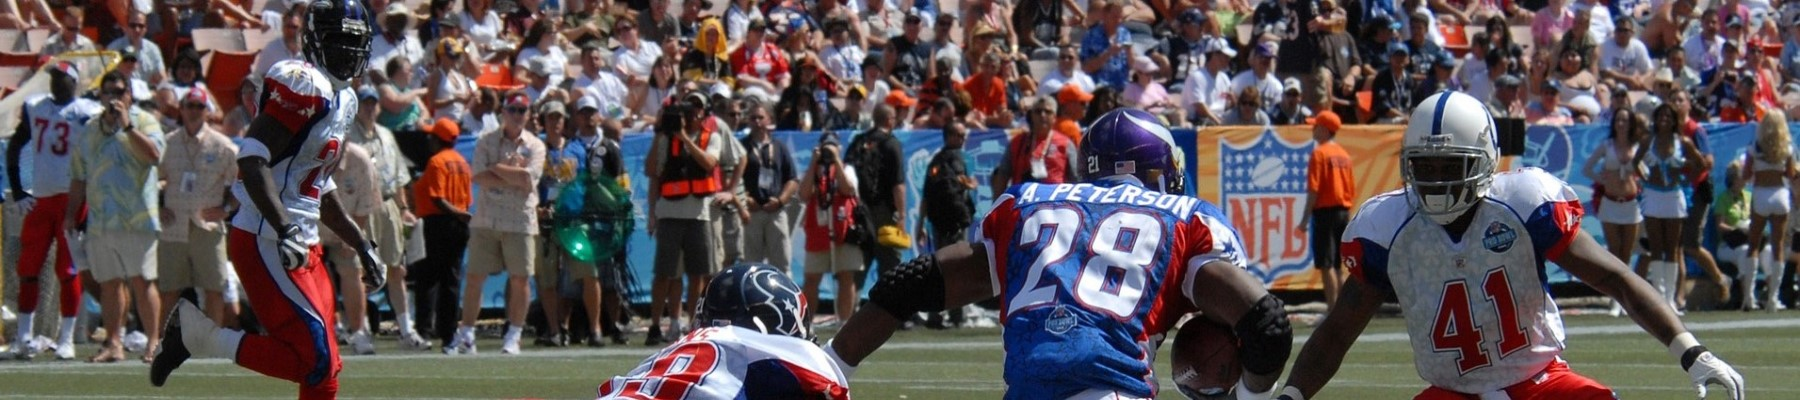

In [ ]:
# modules we'll use
# Carregando as bibliotecas necessárias
import pandas as pd
import numpy as np

# read in all our data
# Lendo os dados
nfl_data = pd.read_csv('/content/NFL Play by Play 2009-2016 (v3).csv')

# set seed for reproducibility
# Criando uma semente para conseguir fazer a reptibilidade dos códigos
np.random.seed(0) 

In [ ]:
# look at the first five rows of the nfl_data file. 
# I can see a handful of missing data already!
# Vamos olhar as primeiras 5 colunas do dataframe, e já podemos observar que temos valores faltando (NaN)
# nas colunas 'yacEPA', 'down', 'airWPA', 'yacWPA'.
nfl_data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009.0
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009.0
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009.0
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009.0
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009.0


In [ ]:
# Uma forma comum para termos uma noção de dados faltantes e também o tipo de dado de cada coluna
# No entanto devido o tamanho do dataset ser muito grande esse comando não funciona
nfl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Columns: 102 entries, Date to Season
dtypes: float64(34), int64(31), object(37)
memory usage: 1.2+ MB


In [ ]:
# get the number of missing data points per column
missing_values_count = nfl_data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Date              0
GameID            0
Drive             0
qtr               0
down            238
time              0
TimeUnder         0
TimeSecs          0
PlayTimeDiff      0
SideofField       3
dtype: int64

In [ ]:
# how many total missing values do we have?
total_cells = np.product(nfl_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

# Pegando a quantidade total de dados faltantes no missing_values_count
qtd= missing_values_count.sum()
print(f'A quantidade total de dados faltantes é: {qtd}')
total=nfl_data.shape
print(f'A quantidade total de dados é: {total[0]*total[1]}')
print(f'O percentual de dados faltantes é: {qtd/(total[0]*total[1])*100}')

24.914199914199912
A quantidade total de dados faltantes é: 39491
A quantidade total de dados é: 158508
O percentual de dados faltantes é: 24.914199914199912


Como podemos ver no resultado anteriror, aproximadamente 25% do dataset contem valores faltantes. 

In [ ]:
# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Date              0
GameID            0
Drive             0
qtr               0
down            238
time              0
TimeUnder         0
TimeSecs          0
PlayTimeDiff      0
SideofField       3
dtype: int64

By looking at the documentation, I can see that this column has information on the number of seconds left in the game when the play was made. This means that these values are probably missing because they were not recorded, rather than because they don't exist. So, it would make sense for us to try and guess what they should be rather than just leaving them as NA's.

On the other hand, there are other fields, like "PenalizedTeam" that also have lot of missing fields. In this case, though, the field is missing because if there was no penalty then it doesn't make sense to say which team was penalized. For this column, it would make more sense to either leave it empty or to add a third value like "neither" and use that to replace the NA's.

Tip: This is a great place to read over the dataset documentation if you haven't already! If you're working with a dataset that you've gotten from another person, you can also try reaching out to them to get more information.

If you're doing very careful data analysis, this is the point at which you'd look at each column individually to figure out the best strategy for filling those missing values. For the rest of this notebook, we'll cover some "quick and dirty" techniques that can help you with missing values but will probably also end up removing some useful information or adding some noise to your data.

In [ ]:
# Informações estatisticas sobre as variaveis numéricas
nfl_data.describe()

,GameID,Drive,qtr,down,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
count,1.554000e+03,1554.000000,1554.000000,1316.000000,1554.000000,1554.000000,1554.000000,1551.000000,1551.000000,1554.000000,...,596.000000,1452.000000,1452.000000,1445.000000,1445.000000,1452.000000,1530.000000,597.000000,595.000000,1553.0
mean,2.009091e+09,12.161519,2.564350,2.018997,7.302445,1702.144788,21.103604,28.362347,48.052869,7.074646,...,-0.285754,0.453749,0.546940,0.453467,0.547225,0.512869,0.002115,0.007351,-0.002849,2009.0
std,9.701706e+01,7.125698,1.121144,1.007397,4.698635,1046.526135,17.172214,13.414108,25.389656,4.674281,...,2.020605,0.275890,0.275773,0.278013,0.277896,0.279440,0.043833,0.065563,0.066815,0.0
min,2.009091e+09,1.000000,1.000000,1.000000,0.000000,-266.000000,0.000000,1.000000,1.000000,0.000000,...,-10.697509,0.000000,0.000000,0.000000,0.000000,0.000000,-0.383699,-0.846499,-0.444653,2009.0
25%,2.009091e+09,6.000000,2.000000,1.000000,3.000000,825.500000,5.250000,19.000000,30.000000,3.000000,...,-0.838463,0.216709,0.372188,0.208496,0.369905,0.334359,-0.015083,-0.016690,-0.014056,2009.0
50%,2.009091e+09,12.000000,3.000000,2.000000,7.000000,1800.000000,18.000000,30.000000,48.000000,9.000000,...,0.000652,0.485759,0.514325,0.486328,0.513781,0.526039,-0.000073,0.000431,0.000012,2009.0
75%,2.009091e+09,18.000000,4.000000,3.000000,11.000000,2582.000000,37.750000,39.000000,70.000000,10.000000,...,0.584320,0.628991,0.784814,0.631842,0.791573,0.694835,0.014912,0.031285,0.014619,2009.0
max,2.009091e+09,28.000000,5.000000,4.000000,15.000000,3600.000000,92.000000,50.000000,99.000000,26.000000,...,6.654746,1.000000,1.000000,1.000000,1.000000,0.999815,0.658596,0.333773,0.532696,2009.0


In [ ]:
# remove all the rows that contain a missing value
data_removed=nfl_data.dropna()
data_removed.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season


Como todas as linhas tem ao menos uma valor nulo, o resultado é um dataset vazio. Agora vamos tentar remover colunas e não remover linhas.

In [ ]:
# remove all columns with at least one missing value
columns_with_na_dropped = nfl_data.dropna(axis=1)
columns_with_na_dropped.head()

,Date,GameID,Drive,qtr,time,TimeUnder,TimeSecs,PlayTimeDiff,ydstogo,ydsnet,...,AwayTeam,Timeout_Indicator,Timeout_Team,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,No_Score_Prob,Opp_Field_Goal_Prob
0,2009-09-10,2009091000,1,1,15:00,15,3600.0,0,0,0,...,TEN,0,None,3,3,3,3,3,0.001506,0.179749
1,2009-09-10,2009091000,1,1,14:53,15,3593.0,7,10,5,...,TEN,0,None,3,3,3,3,3,0.000969,0.108505
2,2009-09-10,2009091000,1,1,14:16,15,3556.0,37,5,2,...,TEN,0,None,3,3,3,3,3,0.001057,0.105106
3,2009-09-10,2009091000,1,1,13:35,14,3515.0,41,8,2,...,TEN,0,None,3,3,3,3,3,0.001434,0.149088
4,2009-09-10,2009091000,1,1,13:27,14,3507.0,8,8,2,...,TEN,0,None,3,3,3,3,3,0.001861,0.213480


In [ ]:
# just how much data did we lose?
print("Columns in original dataset: %d \n" % nfl_data.shape[1])
print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Columns in original dataset: 102 

Columns with na's dropped: 44


# Filling in missing values automatically
---


In [ ]:
# get a small subset of the NFL dataset
subset_nfl_data = nfl_data.loc[:, 'EPA':'Season'].head()
subset_nfl_data

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,NaN,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009.0
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009.0
2,-1.402760,NaN,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009.0
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009.0
4,2.097796,NaN,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009.0


In [ ]:
# replace all NA's with 0
subset_nfl_data.fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,0.000000,0.000000,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,0.000000,0.000000,2009.0
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009.0
2,-1.402760,0.000000,0.000000,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.000000,0.000000,2009.0
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009.0
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009.0


I could also be a bit more savvy and replace missing values with whatever value comes directly after it in the same column. (This makes a lot of sense for datasets where the observations have some sort of logical order to them.)

In [ ]:
# replace all NA's the value that comes directly after it in the same column, 
# then replace all the remaining na's with 0
subset_nfl_data.fillna(method='bfill', axis=0).fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,-1.068169,1.146076,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,-0.032244,0.036899,2009.0
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009.0
2,-1.402760,3.318841,-5.031425,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.106663,-0.156239,2009.0
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009.0
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009.0
